In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_MA
@pyimport GLS_Apr_weekday_PM_ext

In [2]:
numNodes = Compute_Jacobian_MA.numNodes;
numLinks = Compute_Jacobian_MA.numLinks;
numODpairs = Compute_Jacobian_MA.numODpairs;
numZones = Compute_Jacobian_MA.numZones
od_pairs = Compute_Jacobian_MA.od_pairs;
link_list_js = Compute_Jacobian_MA.link_list_js;
link_length_list = Compute_Jacobian_MA.link_length_list;

flow_observ = GLS_Apr_weekday_PM_ext.x_

74x30 Array{Float64,2}:
 1366.35    791.95    771.324  …  1015.01        1624.03     280.272
 1206.76    992.338   991.158     1000.59        1273.13     570.559
 2114.24   1499.68   1200.6       1171.78        1608.83     947.273
 2273.84   1299.3     980.768     1186.21        1959.73     656.986
   58.465   201.97    271.021       86.5748        40.0646   261.282
  139.064   247.675   201.826  …    23.5801       146.69     143.578
 1193.7    1571.81   1353.56       781.132       1109.21    1362.48 
  953.514  1726.49   1642.59       829.701        651.679   1770.47 
 2124.9    1398.79    938.436     1533.92        1629.54    1007.64 
 2365.09   1244.1     649.406     1485.35        2087.07     599.646
  406.406   514.047   567.011  …   469.666        455.737    655.187
  281.997  1677.2    1591.06       204.042        239.965   1660.44 
  204.522   246.959  1020.38         1.2451e-13   268.26    1131.08 
    ⋮                          ⋱                                    
  817.703 

In [3]:
require("../Julia_files/initia_data.jl");
require("prepare_data_MA.jl");
require("extract_data_MA.jl");
require("../Julia_files/tap_MSA.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
demandsDict_ = readall("../08_develop_new_OD_demand_estimator_MA_Dijkstra_uni_class/results/demandsDict1.json");
demandsDict_ = JSON.parse(demandsDict_);

In [5]:
demandsDict__ = demandsDict_["24"]

_demandsDict__ = Dict()

for key_ in keys(demandsDict__)
    key = (int(split(split(key_, ",")[1], "(")[2]),int(split(split(key_, ",")[2], ")")[1]))
    _demandsDict__[key] = demandsDict__[key_]
end

In [6]:
_demandsDict__

Dict{Any,Any} with 484 entries:
  (6,9)   => 0.0
  (18,3)  => 54.44751975676304
  (21,13) => 11.723222210366636
  (22,16) => 0.0
  (15,17) => 43.854936347305944
  (22,14) => 0.0
  (13,9)  => 0.17301819788850809
  (8,9)   => 0.0
  (17,14) => 383.84355492021365
  (9,1)   => 0.0
  (16,6)  => 0.0
  (16,12) => 297.72321415990035
  (16,13) => 733.4176859643633
  (22,2)  => 0.0
  (7,16)  => 459.80532550548673
  (1,12)  => 363.1561006344279
  (11,8)  => 30.991240287021498
  (19,4)  => 0.0
  (18,21) => 0.0
  (4,5)   => 3.7418817398365514
  (20,13) => 7.81392696304233
  (15,4)  => 76.59974560941168
  (6,18)  => 0.0
  (5,16)  => 0.0
  (4,9)   => 0.0
  ⋮       => ⋮

In [7]:
# demandsDict[0] = _demandsDict__;
# demandsDict[1] = _demandsDict__;

In [8]:
demandsDict

Dict{Int64,Dict{(Int64,Int64),Float64}} with 2 entries:
  0 => [(6,9)=>0.0,(18,3)=>0.0,(21,13)=>0.0,(22,16)=>0.0,(15,17)=>0.0,(22,14)=>…
  1 => [(6,9)=>0.0,(18,3)=>0.0,(21,13)=>0.0,(22,16)=>0.0,(15,17)=>0.0,(22,14)=>…

In [9]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [10]:
demandsDiffDict[1]

0.0

In [11]:
week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

day = 21  # day of April

21

In [12]:
# observed flow vector
xl = flow_observ[:, day]

74-element Array{Float64,1}:
 1069.47       
  821.886      
 1286.29       
 1533.87       
   99.5381     
   73.9925     
  482.609      
  260.575      
  864.537      
 1086.57       
  208.225      
  212.37       
  119.4        
    ⋮          
  740.221      
  545.195      
  413.692      
  344.281      
    5.43899e-10
    5.43899e-10
   94.6625     
   94.6625     
  653.185      
  822.96       
  859.239      
  689.464      

In [13]:
tapFlows = Dict{(Int64,Int64),Float64}()

for i = 1:length(ta_data.start_node)
    key = (ta_data.start_node[i], ta_data.end_node[i])
    tapFlows[key] = xl[i]
end

tapFlowVect = xl;

In [14]:
# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapFlows, tapFlowVect;

In [15]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/MA_net.txt", tapFlowDicDict[0]);

In [16]:
arcsDict[0]

Dict{(Int64,Int64),Arc} with 74 entries:
  (17,15) => Arc(17,15,5941.509547,0.243392,822.9599619721723)
  (3,6)   => Arc(3,6,6438.424264,0.117963,864.5373015750429)
  (21,13) => Arc(21,13,2068.636909,0.103075,301.1029667129198)
  (22,16) => Arc(22,16,5826.794762,0.118731,5.438987823952629e-10)
  (19,12) => Arc(19,12,5540.728327,0.069605,171.69156960443183)
  (22,14) => Arc(22,14,4285.78757,0.079134,94.6625069078315)
  (15,17) => Arc(15,17,5726.051257,0.245197,653.1852219799919)
  (10,11) => Arc(10,11,2934.51529,0.211194,507.16466419361603)
  (13,12) => Arc(13,12,918.190114,0.474671,1.0120739549067401e-13)
  (3,1)   => Arc(3,1,8000.0,0.179745,1533.8713316973142)
  (16,13) => Arc(16,13,6695.591725,0.169855,545.194989091963)
  (4,5)   => Arc(4,5,6000.0,0.043136,720.0459623709298)
  (13,16) => Arc(13,16,6242.577967,0.158994,740.2210641798455)
  (17,16) => Arc(17,16,5877.602649,0.208304,689.4644472180155)
  (20,13) => Arc(20,13,2251.546038,0.137259,279.5823134995158)
  (12,8)  => Arc(12,8,6

In [17]:
deg = 4
c = 0.5
lam = 100.0

coeffs_dict_Apr_PM_ = readall("../temp_files/coeffs_dict_Apr_PM.json")
coeffs_dict_Apr_PM_ = JSON.parse(coeffs_dict_Apr_PM_)
# fcoeffs = coeffs_dict_Apr_PM_["($(deg),$(c),$(lam),1)"]

fcoeffs = [1, 0, 0, .15]

4-element Array{Float64,1}:
 1.0 
 0.0 
 0.0 
 0.15

INFO: Loading help data...


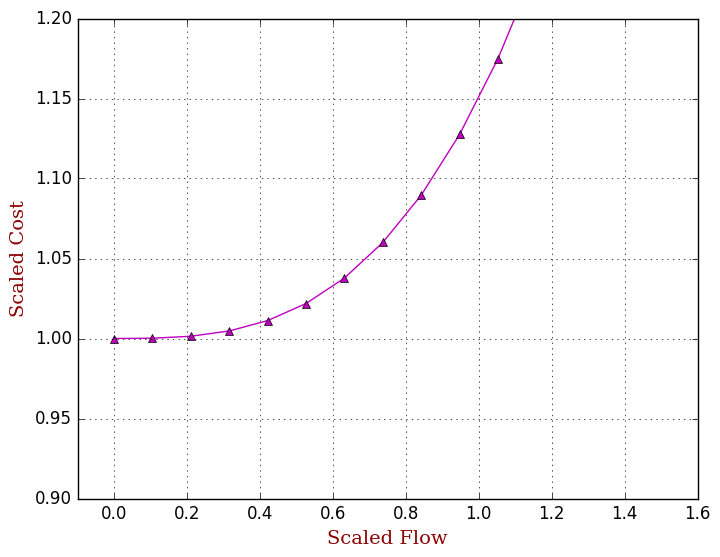

In [18]:
using PyPlot

est_coeffs = fcoeffs

xs = linspace(0, 2, 20)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs, "^-m")

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 1.2);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_MA.pdf")

In [19]:
demandsVecDict[1] = demandsDicToVec(demandsDict[1]);
objFunDict[1] = objF(demandsVecDict[1], fcoeffs);

In [20]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], fcoeffs);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [21]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/MA_net.txt", tapFlowDicDict[1]);

In [22]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], fcoeffs);

In [23]:
linkCostDicDict[1]["0"], link_length_list[1]

(0.1649898192336673,0.0)

In [24]:
jacobiSpiessDict[1] = Compute_Jacobian_MA.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [25]:
# maximum number of iterations
N = 100;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [26]:
for l = 1:N
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(objFunDict[l], demandsVecDict[l], fcoeffs, searchDirecDict[l], 
    thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], fcoeffs);
        
    arcsDict[l+1] = observFlow("./benchmark_data/MA_net.txt", tapFlowDicDict[l+1]);
        
    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], fcoeffs);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_MA.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
  
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [27]:
demandsVecDict

Dict{Any,Any} with 21 entries:
  18 => [2.7011214534173393,64.11112714381733,285.48335137839615,0.0,101.674467…
  2  => [0.0,8.194298015027659,337.3282562795663,0.0,13.701816020439942,249.025…
  16 => [2.0483164980727717,60.44184492400829,285.92989755703877,0.0,96.2358986…
  11 => [0.0,38.857992854571194,292.19639713648337,0.0,63.25714023690994,111.63…
  0  => [0.0,0.0,364.030563,0.0,0.0,325.36421,0.0,0.0,0.0,0.0,387.087581,543.74…
  7  => [0.0,12.889312283711856,327.8707365633806,0.0,21.413201155849894,221.02…
  9  => [0.0,20.310095335678668,315.1928372738682,0.0,33.49901154242475,183.179…
  10 => [0.0,22.07610455499057,312.8611151815925,0.0,36.34088032073167,175.9876…
  19 => [3.8337080159485817,70.19679297182125,284.8492985971607,0.0,110.6252492…
  17 => [2.6813550783191813,64.00478905713788,285.4944820944362,0.0,101.5180300…
  8  => [0.0,18.998404972321545,317.0145823835829,0.0,31.38304719399462,188.761…
  6  => [0.0,12.292763381770115,328.95355044249203,0.0,20.43856811668011,224.2

In [28]:
norObjFunDict

Dict{Any,Any} with 20 entries:
  18 => 0.11685645782285983
  2  => 0.5882706714210775
  16 => 0.12281469321811116
  11 => 0.18026744912813267
  7  => 0.478361047493296
  9  => 0.3637023574725201
  10 => 0.3406017073035087
  19 => 0.10784840892266537
  17 => 0.117019820839416
  8  => 0.3783819060734307
  6  => 0.48974523906185546
  4  => 0.5645835094826073
  3  => 0.5806562372639943
  5  => 0.5604528477405474
  20 => 0.10784840892266537
  13 => 0.1404169482513499
  14 => 0.1258678460550589
  15 => 0.12402835871446453
  12 => 0.1653652811144667
  1  => 1.0

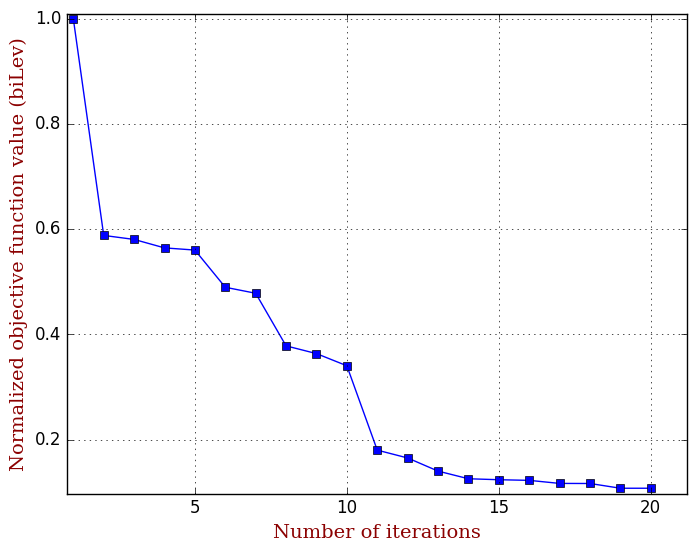

In [29]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_MA.pdf")

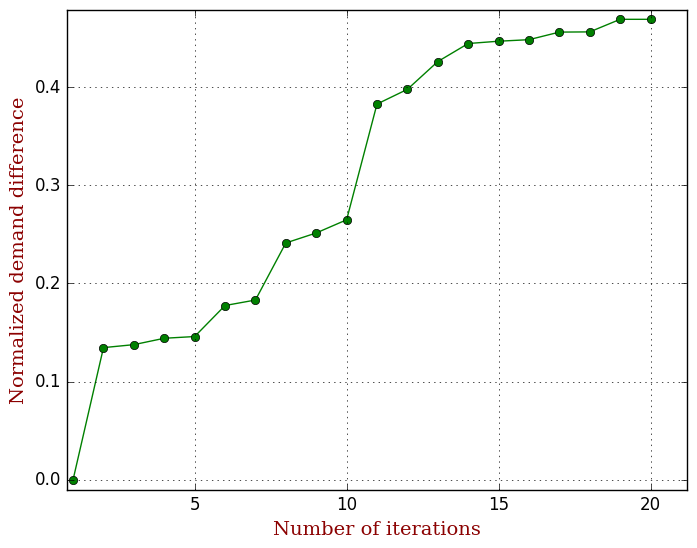

In [30]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.01, maximum(demandsDiff)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_MA.pdf")

In [31]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [32]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [33]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [34]:
outfile = open("./results/demandsDict$(day).json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [35]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [36]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)

In [37]:
demandsDict[length(demandsDict)-1]

Dict{(Int64,Int64),Float64} with 484 entries:
  (6,9)   => 0.0
  (18,3)  => 24.547818301506833
  (21,13) => 15.716980355636936
  (22,16) => 0.0
  (15,17) => 24.19880198985159
  (22,14) => 0.0
  (13,9)  => 2.719096498171676
  (8,9)   => 0.0
  (9,1)   => 0.0
  (17,14) => 308.1167151933829
  (16,6)  => 0.0
  (16,12) => 220.0534254881345
  (16,13) => 721.782217809197
  (22,2)  => 0.0
  (7,16)  => 429.73343633431944
  (1,12)  => 300.29233000247325
  (4,5)   => 0.0
  (11,8)  => 48.0955147754518
  (18,21) => 0.0
  (19,4)  => 0.0
  (20,13) => 14.205542939245273
  (15,4)  => 31.163752711433375
  (6,18)  => 0.5146118119300102
  (5,16)  => 0.0
  (4,9)   => 0.0
  ⋮       => ⋮

In [38]:
outfile = open("./results/demandsDictFixed.json", "w")

JSON.print(outfile, demandsDict[length(demandsDict)-1])

close(outfile)